In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from itertools import combinations
from math import prod, log
from sklearn.linear_model import LinearRegression
import pymc as pm
import pymc.math as math
import pytensor.tensor as pt
import arviz as az
np.set_printoptions(suppress=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
trial_per_block = 50
nCondition = 6
nTrial = 9600
nBlock = 32
nPara = 6
nCondition = 6
nSubject = 13
nDifficulty = 3

In [3]:
def compute_curve(para_set, coef_matrix):
    n_combine = [1,2,3,4,5,6]
    index = [0,1,2,3,4,5]
    feature_arr = np.array([])
    for n in n_combine:
        combine = list(combinations(index, n))
        for current_combine in combine:
            feature_arr = np.append(feature_arr, np.prod(para_set[list(current_combine)]))
    feature_arr = np.append(feature_arr, 1)
    return (feature_arr @ coef_matrix.T).reshape((nCondition,nBlock))

def curve_set_generator(log_mean, log_std, coef_matrix, n_curve):
# this function generate curves based on mean and std
# curve_set (n_curve, 6, 32)
    curve_set = np.array([])
    for i in range(n_curve):
        para_set = np.exp(np.random.normal(log_mean, log_std))
        curve_set = np.append(curve_set, np.clip(compute_curve(para_set, coef_matrix), 0.0001, 0.9999))        
    return curve_set.reshape((n_curve,nCondition, nBlock))

def to_block_prob(input_string):
    remove_elements = ['\n', '[', ']']
    for element in remove_elements:
        input_string =  input_string.replace(element, '')
    input_string = input_string.split()
    output_arr =  [float(string) for string in input_string]
    return np.array(output_arr)


def to_para_set(input_string):
    remove_elements = ['[', ']']
    for element in remove_elements:
        input_string =  input_string.replace(element, '')
    input_string = input_string.split()
    para_set =  np.array([float(string) for string in input_string])
    feature_arr = []
    n_combine = [1,2,3,4,5,6]
    index = [0,1,2,3,4,5]
    for n in n_combine:
        combine = list(combinations(index, n))
        for current_combine in combine:
            feature_arr.append(prod(para_set[list(current_combine)]))
    return np.array(feature_arr)

def generate_z_true_curve(iSubject, z = True):
    df_true = pd.read_csv('Data_withfeedback.csv')[iSubject * nTrial : (iSubject + 1) * nTrial]
    correct = df_true['Correct'].values
    contrast = df_true['Contrast'].values
    congruent = df_true['Congruent'].values
    li = np.intersect1d(np.where(contrast==0.10),np.where(congruent==0))
    mi = np.intersect1d(np.where(contrast==0.15),np.where(congruent==0))
    hi = np.intersect1d(np.where(contrast==0.23),np.where(congruent==0))
    lc = np.intersect1d(np.where(contrast==0.10),np.where(congruent==1))
    mc = np.intersect1d(np.where(contrast==0.15),np.where(congruent==1))
    hc = np.intersect1d(np.where(contrast==0.23),np.where(congruent==1))
    learning_curve = correct[np.stack([li, mi, hi, lc, mc, hc])].reshape(nCondition,nBlock,trial_per_block).sum(axis=2)/trial_per_block
    if z == True:
        learning_curve = stats.norm.ppf(learning_curve)
    return learning_curve

def generate_z_simu_curve(coef_matrix, iSubject = None, n_curve = 1000, z = True, log_mean = None, log_std = None):
    if iSubject != None:
        df_simu = pd.read_csv('results/HBM Solution_NUTS.csv')[78 + iSubject * 6 : 78 + (iSubject + 1) * 6]
        log_mean = df_simu['mean'].values
        log_std = df_simu['sd'].values
        curve_set = curve_set_generator(log_mean, log_std, coef_matrix, n_curve)
    else:
        curve_set = curve_set_generator(log_mean, log_std, coef_matrix, n_curve)
    if z == True:
        z_curve_set = stats.norm.ppf(curve_set)
        z_simu = np.mean(z_curve_set, axis = 0)
        z_simu_std = np.std(z_curve_set, axis = 0)
        return z_simu, z_simu_std
    else:
        simu = np.mean(curve_set, axis = 0)
        simu_std = np.std(curve_set, axis = 0)
        return simu, simu_std
    
def log_to_normal(log_mean, log_std):
    log_N = np.random.normal(log_mean, log_std, (10000,6))
    N = np.exp(log_N)
    return np.mean(N, axis = 0), np.std(N, axis = 0)

def normal_to_d(a_mean,b_mean,a_std,b_std):
    a = np.random.normal(a_mean, a_std, (10000,32))
    b = np.random.normal(b_mean, b_std, (10000,32))
    avg = np.clip((a+b)/2,0.0001,0.9999)
    d_avg = stats.norm.ppf(avg) - stats.norm.ppf(1-avg)
    return np.std(d_avg, axis = 0)

In [4]:
def load_data_and_return_matrix(file_path):
    # This functionr reads the grid search file and output the coefficient matrix with contains 63 combinations of 6 paras and 1 intercept.
    # coef_matrix (192, 64)
    search_grid = pd.read_csv(file_path, header = None).values
    X_train, y_train = [], []
    for i in range(len(search_grid)):
        X_train.append(to_para_set(search_grid[i][1]))
        y_train.append(to_block_prob(search_grid[i][2]))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    coef_matrix = np.array(())
    for block in range(y_train.shape[1]):
        y_subtrain = y_train[:,block]
        model = LinearRegression()
        model.fit(X_train, y_subtrain)
        w = np.append(model.coef_,model.intercept_)
        coef_matrix = np.append(coef_matrix, w)
    coef_matrix = coef_matrix.reshape(y_train.shape[1],w.shape[0])
    return coef_matrix
coef_matrix = load_data_and_return_matrix('search grid 6_4.csv')

In [19]:
def draw_z_curve(z_simu_curve, z_simu_std, z_true_curve, iSubject = 0, y_min = -1, y_max = 3.5):
    title={0:'Incongruent stimuli', 1: 'Congruent stimuli'}
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    axes=[ax1,ax2]
    for i in [0,1]:
        low_simu, low_true, low_std = z_simu_curve[i*3],  z_true_curve[i*3], z_simu_std[i*3]
        normal_simu, normal_true, normal_std = z_simu_curve[i*3+1],  z_true_curve[i*3+1], z_simu_std[i*3+1]
        high_simu, high_true, high_std = z_simu_curve[i*3+2],  z_true_curve[i*3+2], z_simu_std[i*3+2]
        start=[0,1,9,17,25,31,32]
        for j in range(6):
            part = np.arange(start[j],start[j+1])
            low_simu_part, normal_simu_part, high_simu_part = low_simu[part],normal_simu[part],high_simu[part]
            axes[i].plot(part, low_simu_part, color='black', marker='s', markersize=5)
            axes[i].plot(part, normal_simu_part, color='black', marker='o', markersize=5)
            axes[i].plot(part, high_simu_part, color='black', marker='^', markersize=5)

            axes[i].fill_between(part, low_simu[part] -  low_std[part],  low_simu[part] +  low_std[part], color='blue', alpha = 0.3)
            axes[i].fill_between(part, normal_simu[part] -  normal_std[part],  normal_simu[part] +  normal_std[part], color='blue',  alpha = 0.3)
            axes[i].fill_between(part, high_simu[part] -  high_std[part],  high_simu[part] +  high_std[part], color='blue',  alpha = 0.3)


        axes[i].plot(low_true, marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10')
        axes[i].plot(normal_true, marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15')
        axes[i].plot(high_true, marker='^', color='black',linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')
        axes[i].set_ylabel('z-probability correct')
        axes[i].set_xlabel('Block number (300 trials/block, 4 blocks/day)')
        axes[i].set_title(title.get(i))
        axes[i].set_ylim(y_min, y_max)
    legend_handles = [plt.Line2D([],[],marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                      plt.Line2D([],[],marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                      plt.Line2D([],[],marker='^',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23'),
                      plt.Line2D([], [], color='black', marker='o',markersize=3, linestyle='None', label='Model fits'),]
    plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.2, 0))
    plt.savefig(f'results/z_curve/Subject_{iSubject}',bbox_inches='tight')
    plt.show()
    return    

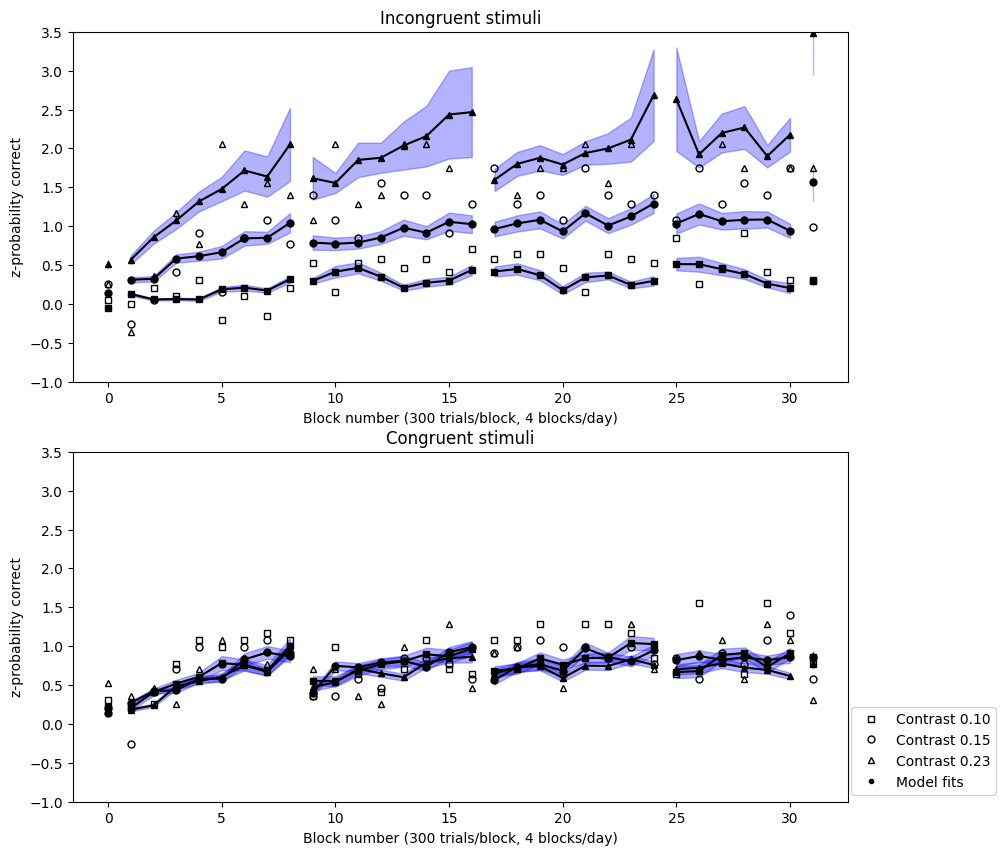

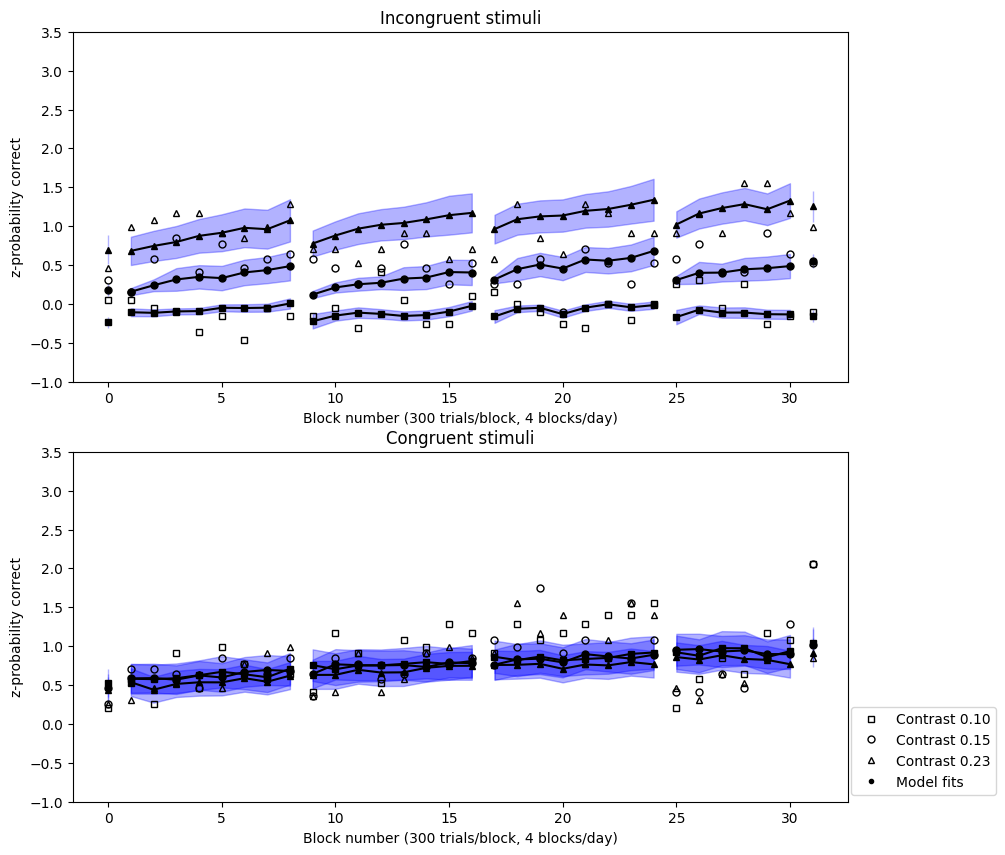

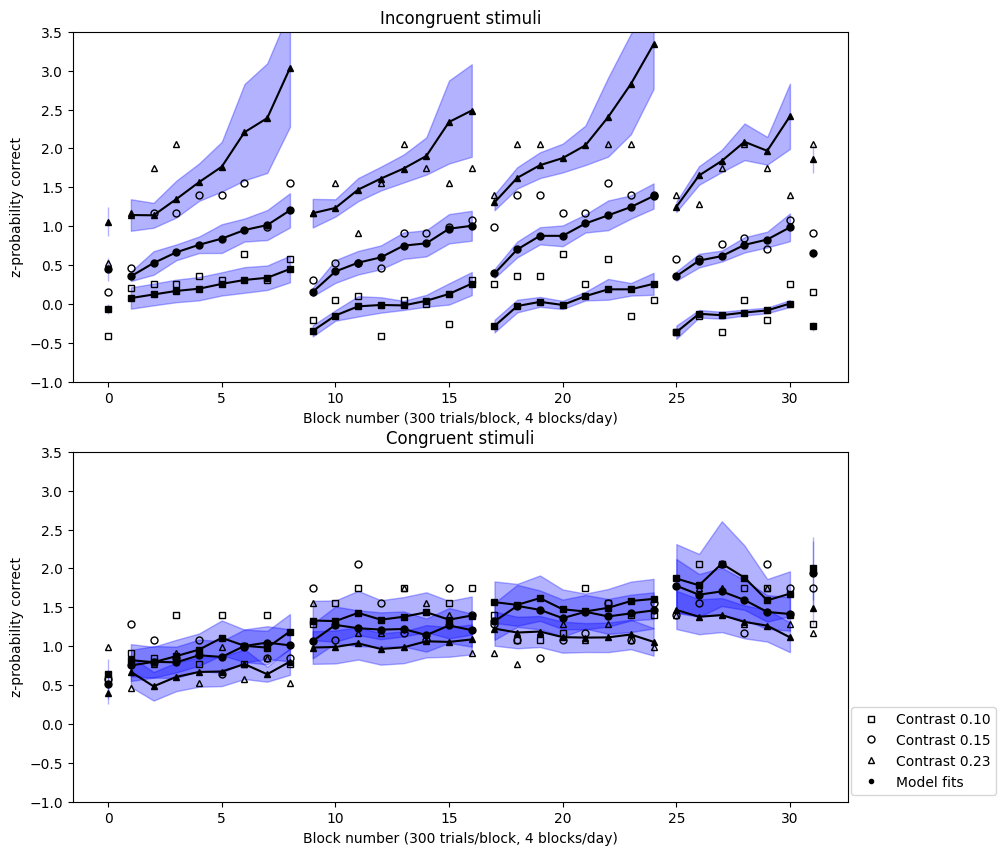

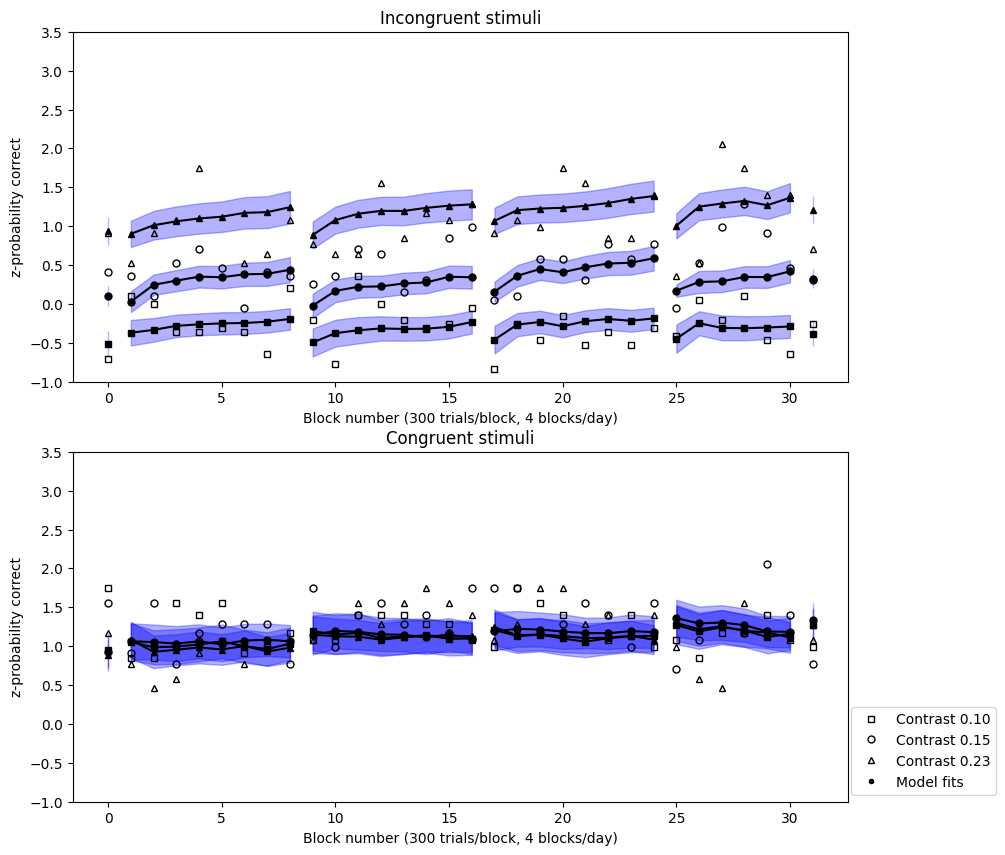

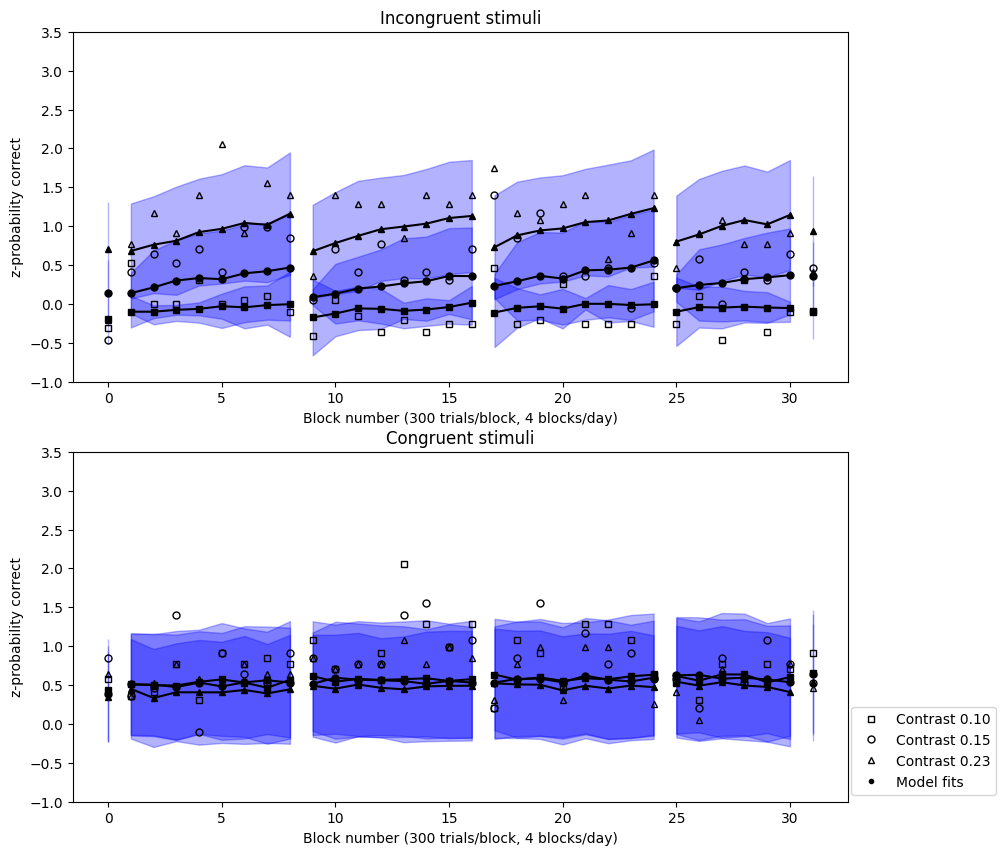

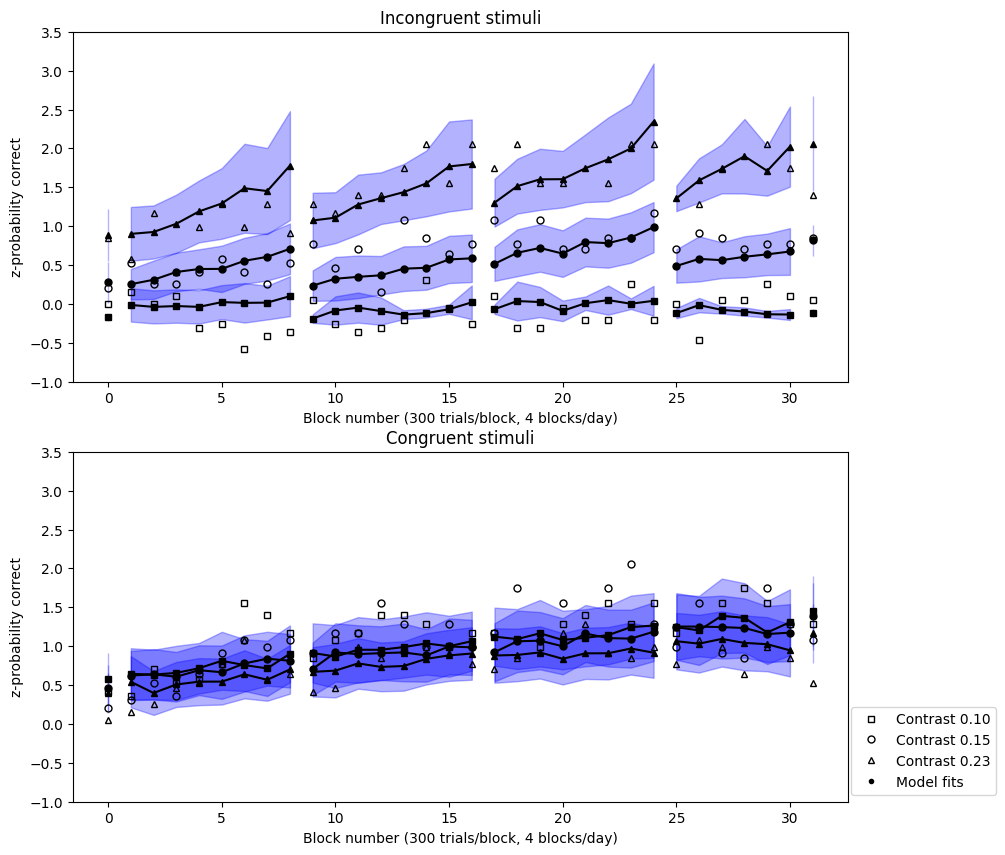

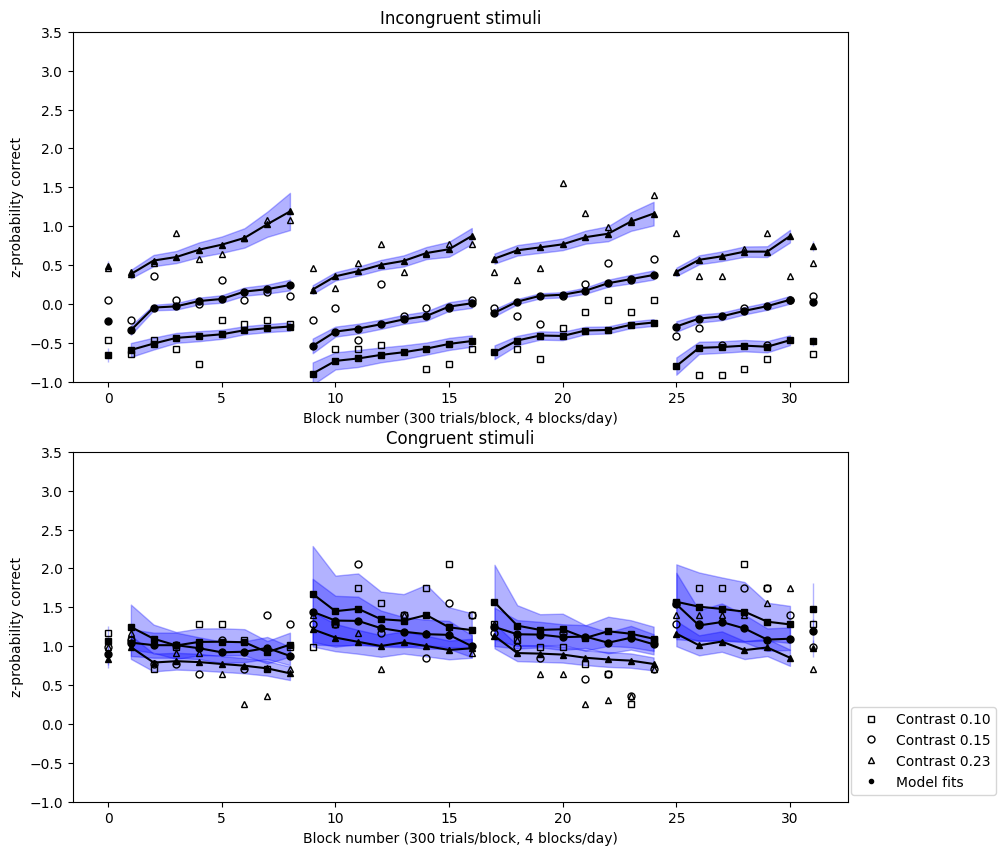

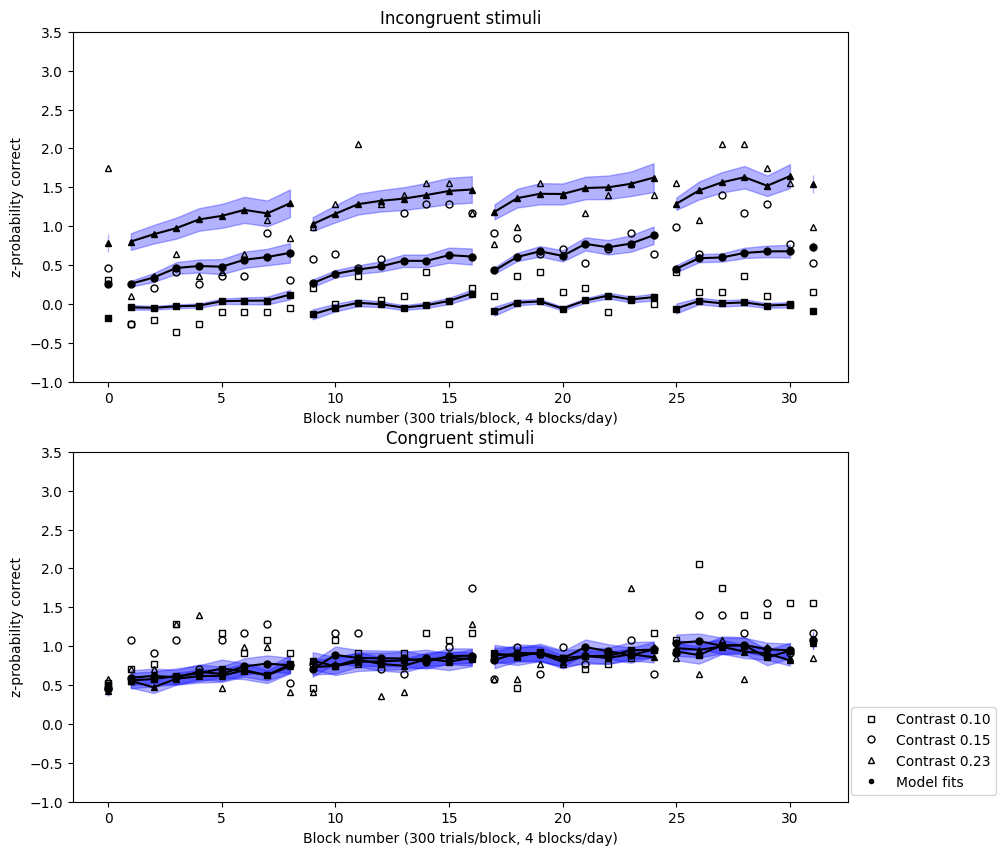

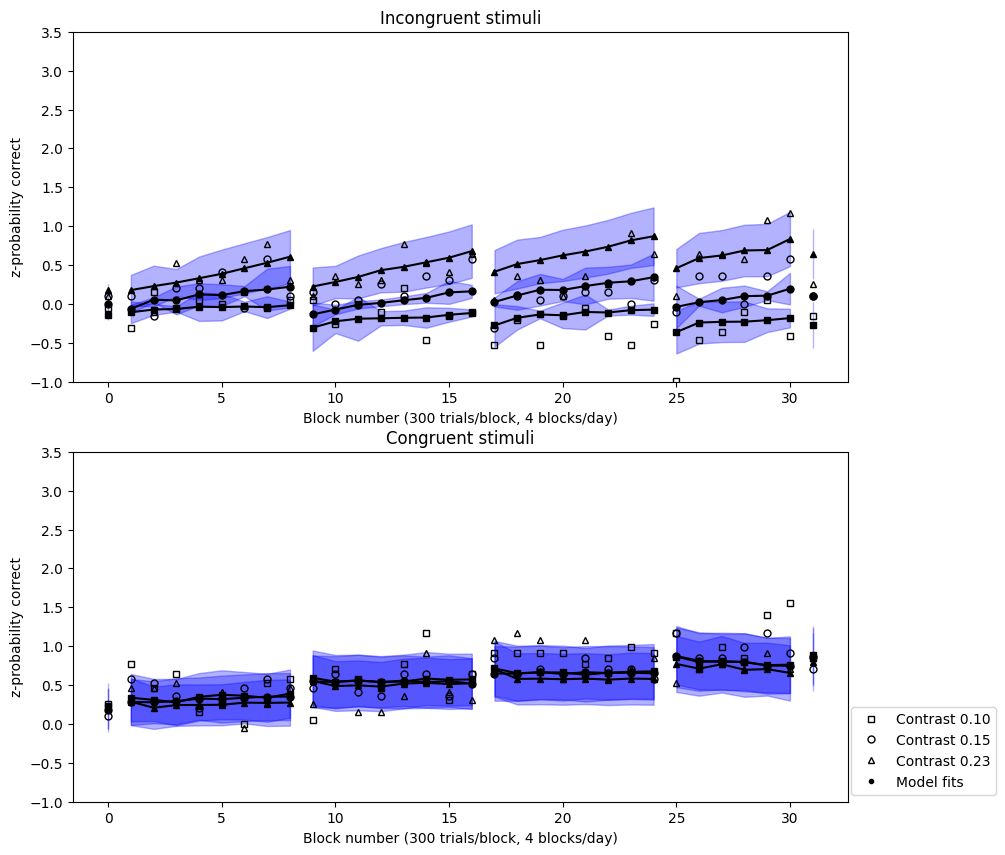

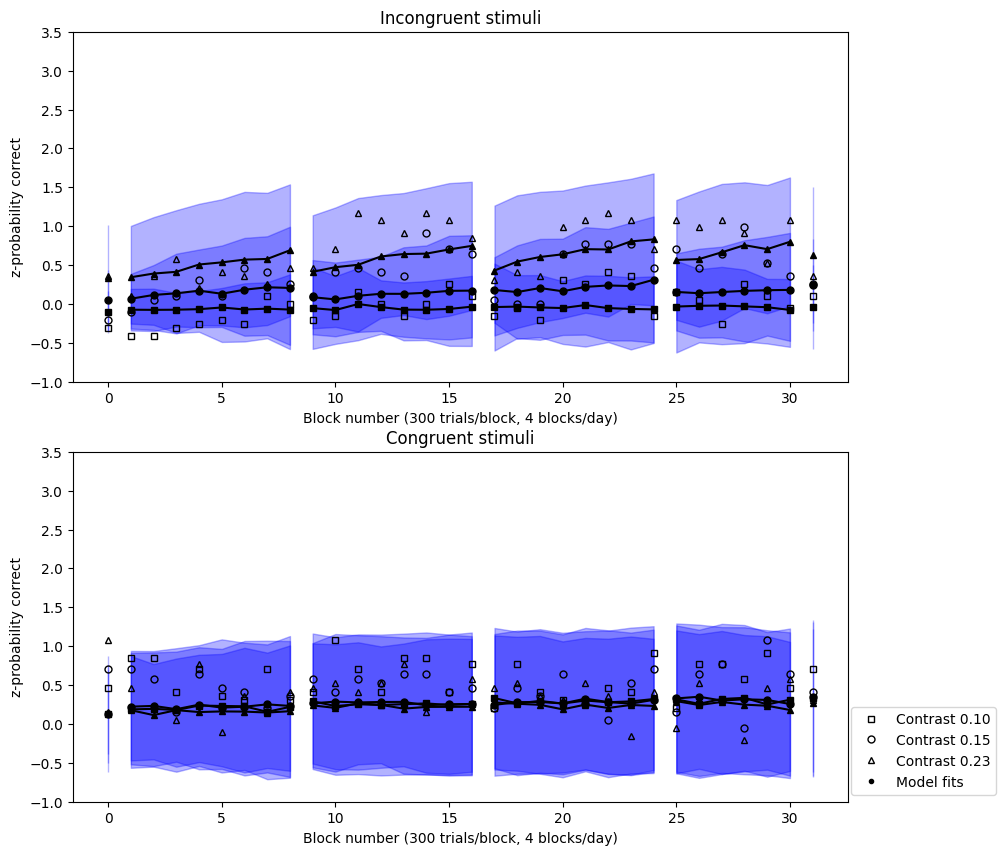

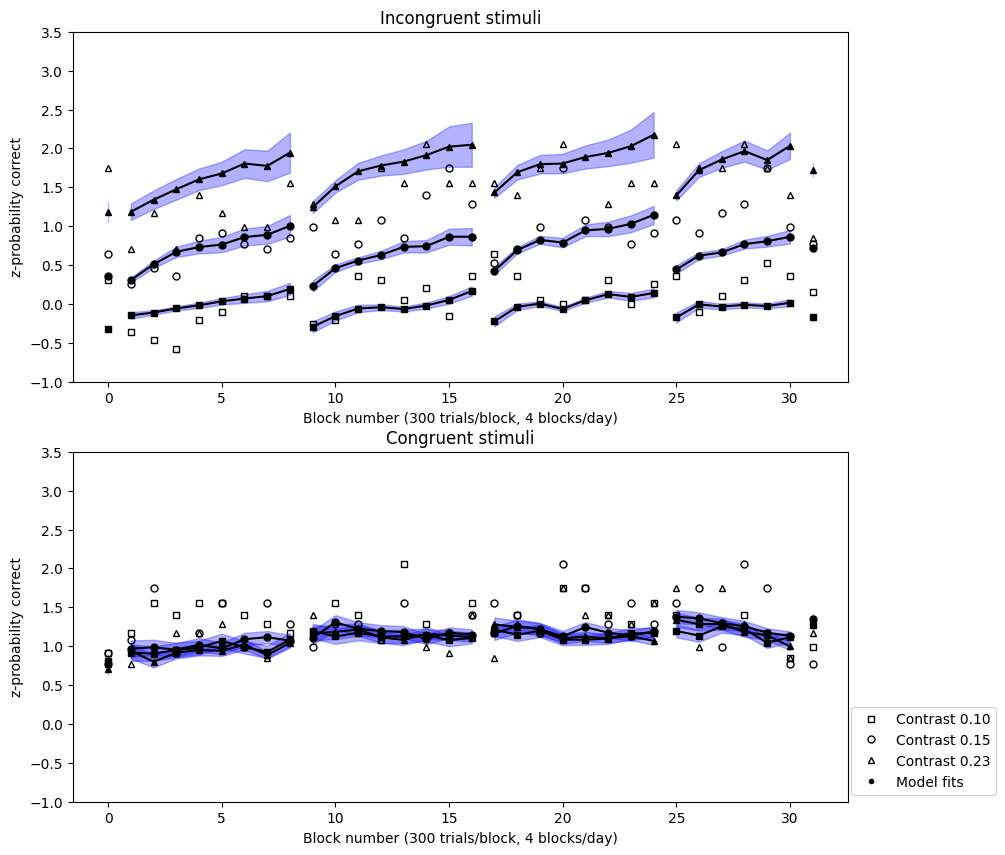

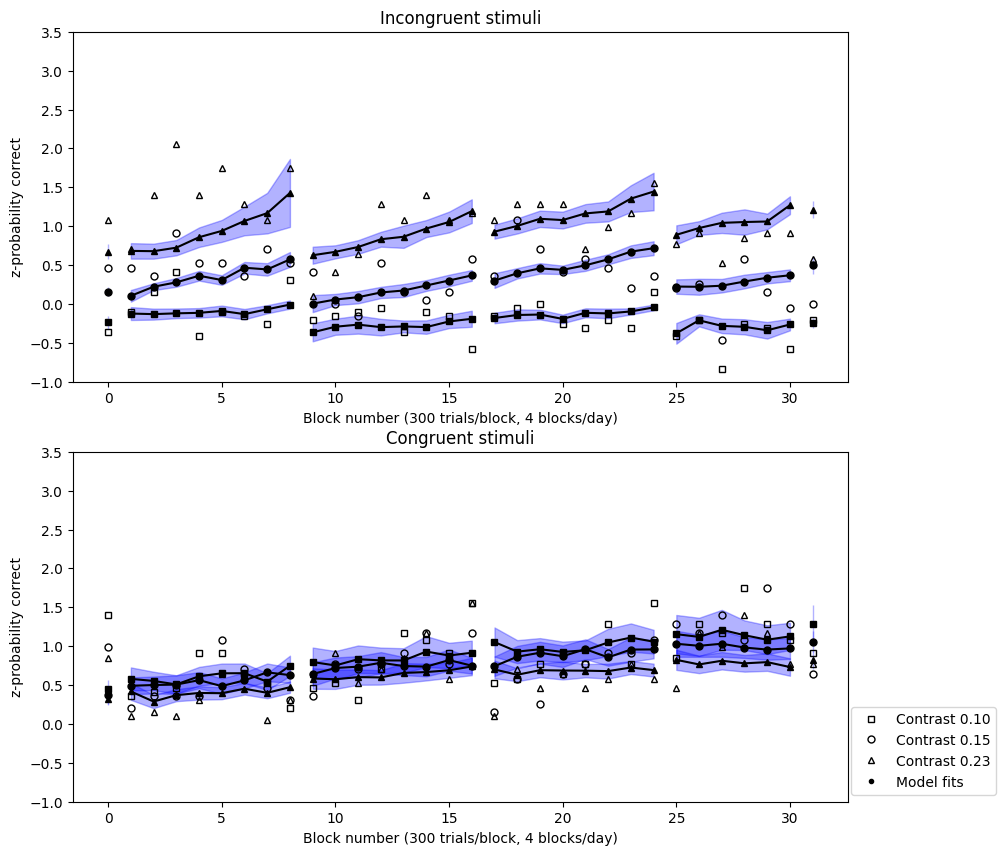

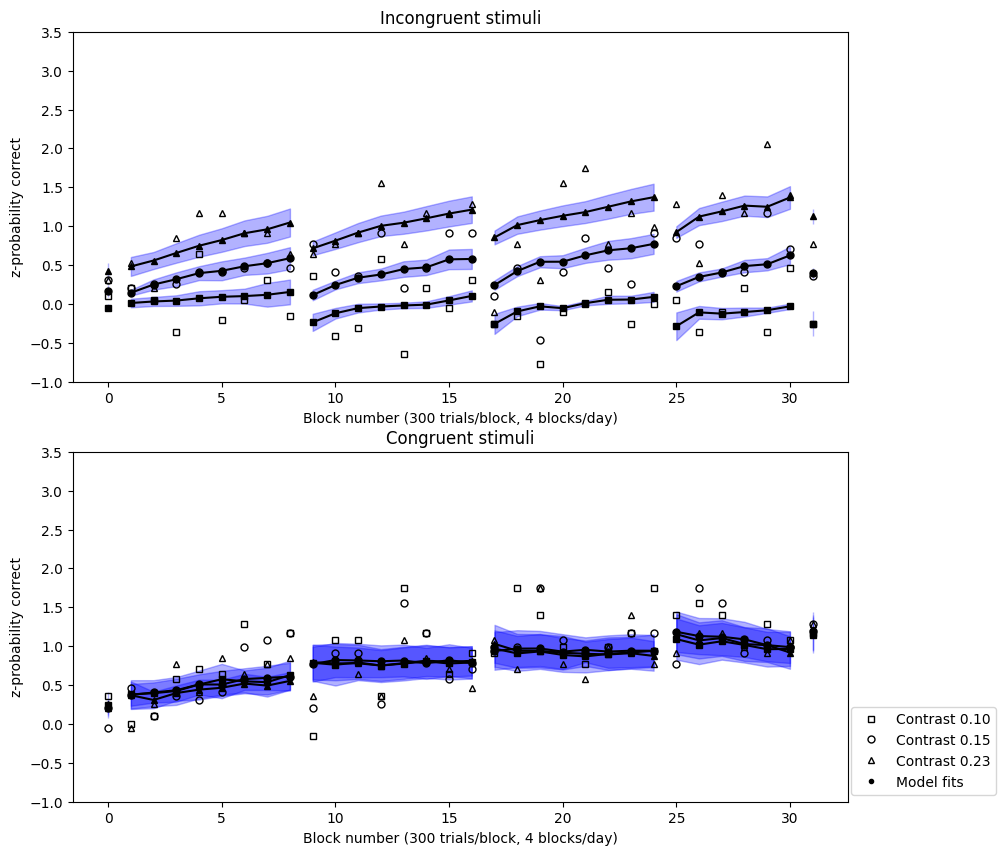

In [15]:
def subject_z_curve(coef_matrix, iSubject):
    z_simu_curve, z_simu_std =  generate_z_simu_curve(coef_matrix, iSubject = iSubject)
    z_true_curve = generate_z_true_curve(iSubject)
    draw_z_curve(z_simu_curve, z_simu_std, z_true_curve, iSubject)
    return
for i in range(nSubject):
    subject_z_curve(coef_matrix, iSubject = i)

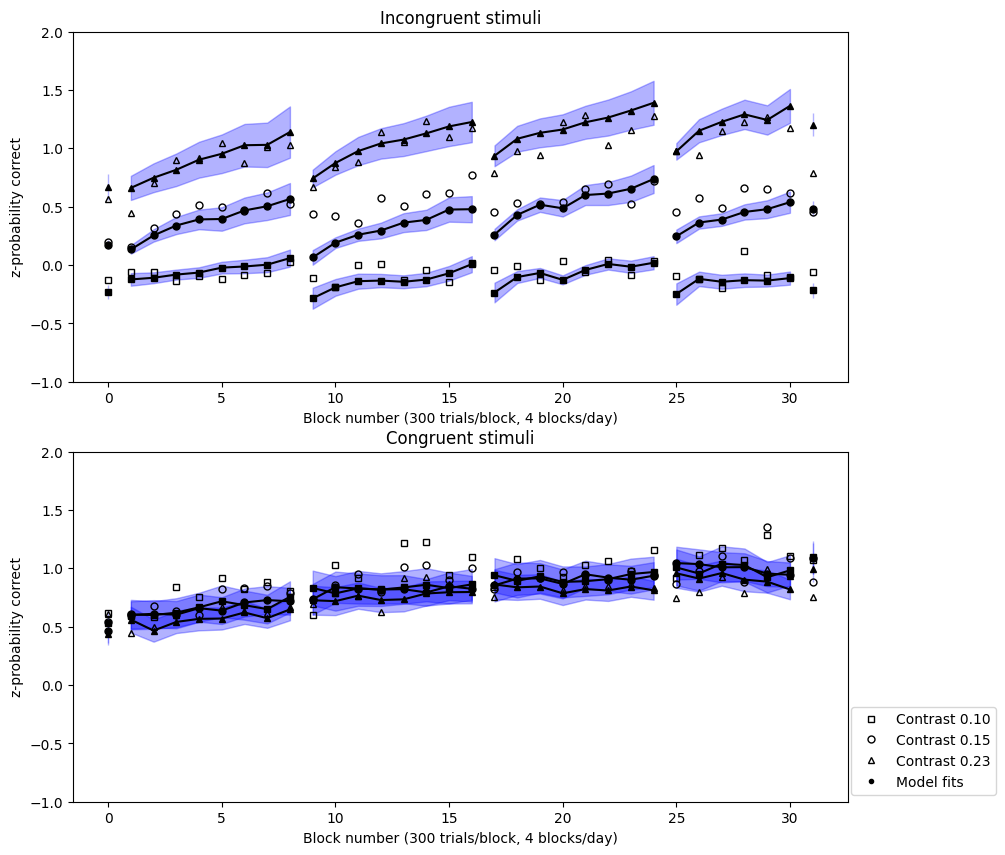

In [20]:
def population_z_curve(coef_matrix):
    pop_true_curve = np.zeros((nSubject, nCondition, nBlock))
    for iSubject in range(nSubject):
        pop_true_curve[iSubject] = generate_z_true_curve(iSubject, z = False)
    pop_true_curve = np.mean(pop_true_curve, axis = 0)
    pop_z_true_curve = stats.norm.ppf(pop_true_curve)
    log_mean = pd.read_csv('results/Population solution_NUTS.csv')['mean'][0:6]
    log_std = pd.read_csv('results/Population solution_NUTS.csv')['sd'][0:6]
    pop_z_simu_curve, pop_z_simu_std = generate_z_simu_curve(coef_matrix, log_mean = log_mean, log_std = log_std)
    draw_z_curve(pop_z_simu_curve, pop_z_simu_std, pop_z_true_curve, y_max = 2)
    return 
population_z_curve(coef_matrix)

In [14]:
Population_data = az.from_json('results/Population inference data.json')

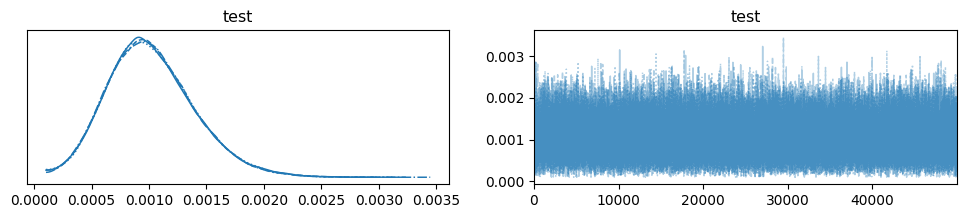

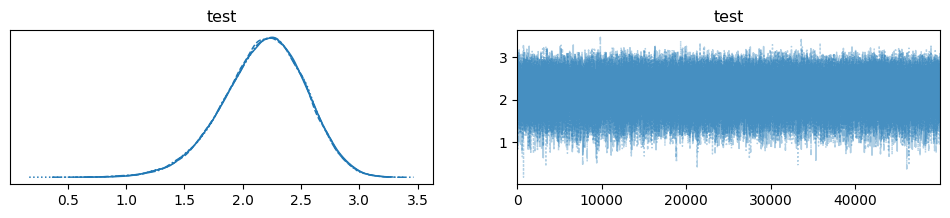

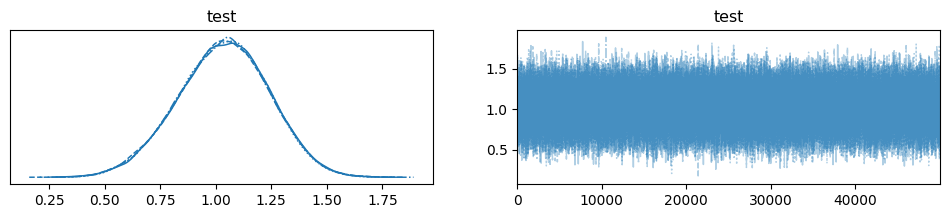

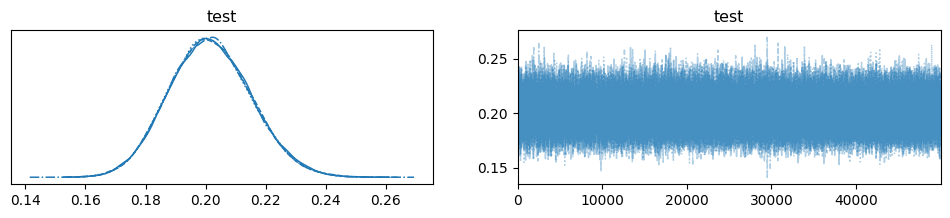

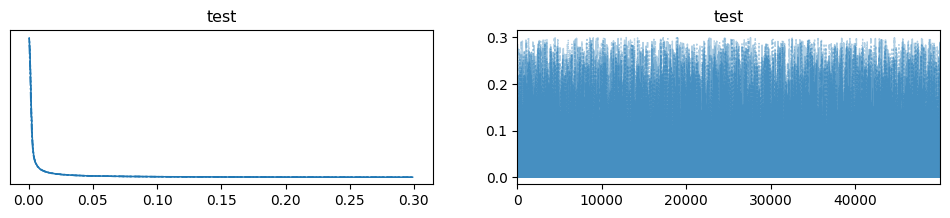

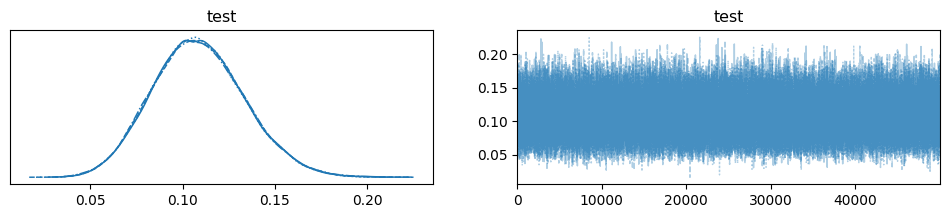

In [121]:
para = np.exp(Population_data.posterior["test"])
for i in range(para.shape[-1]):
    az.plot_trace(para[..., i])

In [87]:
# HBM correlation
'''
nPara=6
iChain=0 #select the chain (three in total)
iSubject=1 #subject index
for i in range(nPara):
     # this loop travel through all theta combinations
    for j in range(i):
        #load theta trace
        theta_collection=Population_data.posterior['test'].values[iChain]

            #specify theta[]
        a=theta_collection[:,iSubject,i]
        b=theta_collection[:,iSubject,j]

            #bound and step for heat map
        a_max, a_min, a_len = max(a), min(a), (max(a)- min(a))/100
        b_max, b_min, b_len = max(b), min(b), (max(b)- min(b))/100

            #plot heatmap
        corrcoef=np.corrcoef(a,b)[0,1].round(4)
        heatmap = plt.hist2d(a, b, bins = (np.arange(a_min,a_max,a_len),np.arange(b_min,b_max,b_len)), cmap = 'hot')
        plt.colorbar()
        plt.title(f'corrcoef={corrcoef}')
        plt.xlabel(f'theta{i+1}')
        plt.ylabel(f'theta{j+1}')
        plt.show()
'''

"\nnPara=6\niChain=0 #select the chain (three in total)\niSubject=1 #subject index\nfor i in range(nPara):\n     # this loop travel through all theta combinations\n    for j in range(i):\n        #load theta trace\n        theta_collection=Population_data.posterior['test'].values[iChain]\n\n            #specify theta[]\n        a=theta_collection[:,iSubject,i]\n        b=theta_collection[:,iSubject,j]\n\n            #bound and step for heat map\n        a_max, a_min, a_len = max(a), min(a), (max(a)- min(a))/100\n        b_max, b_min, b_len = max(b), min(b), (max(b)- min(b))/100\n\n            #plot heatmap\n        corrcoef=np.corrcoef(a,b)[0,1].round(4)\n        heatmap = plt.hist2d(a, b, bins = (np.arange(a_min,a_max,a_len),np.arange(b_min,b_max,b_len)), cmap = 'hot')\n        plt.colorbar()\n        plt.title(f'corrcoef={corrcoef}')\n        plt.xlabel(f'theta{i+1}')\n        plt.ylabel(f'theta{j+1}')\n        plt.show()\n"

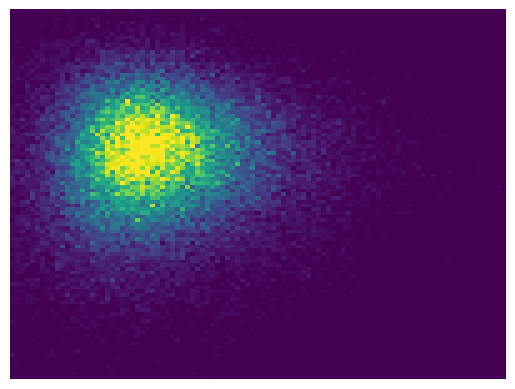

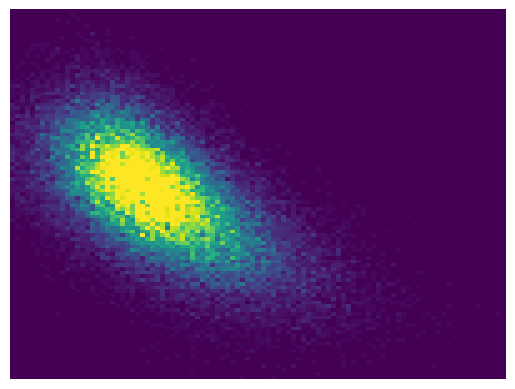

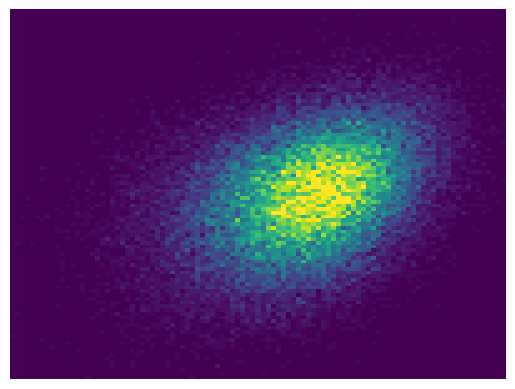

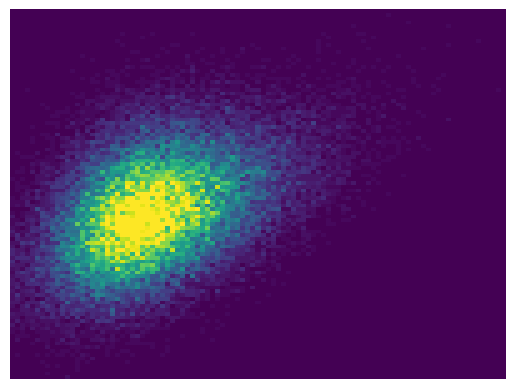

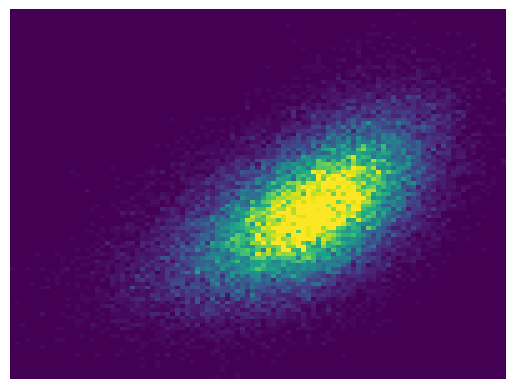

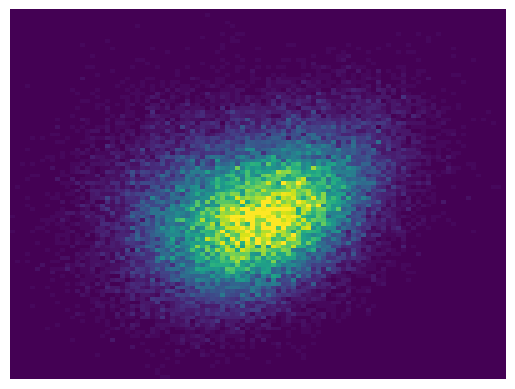

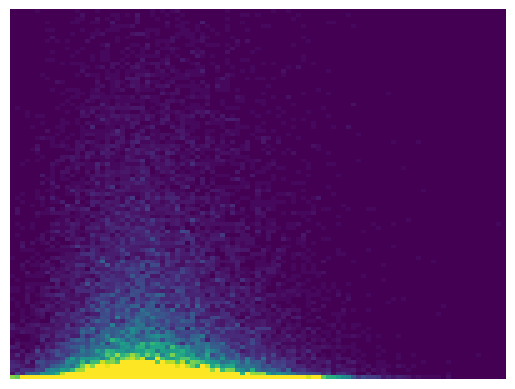

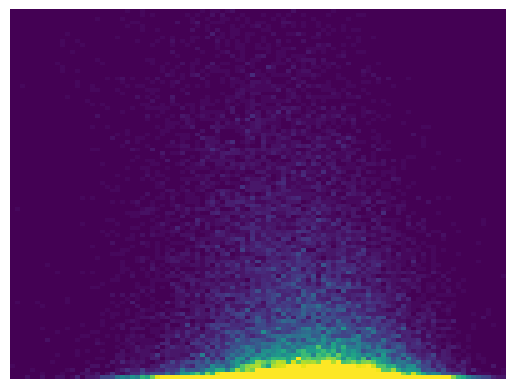

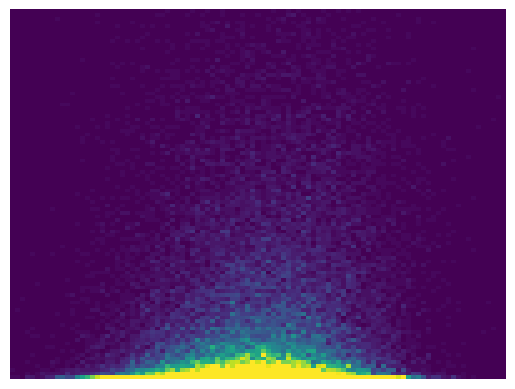

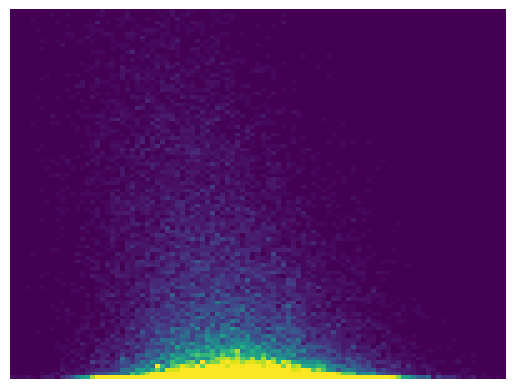

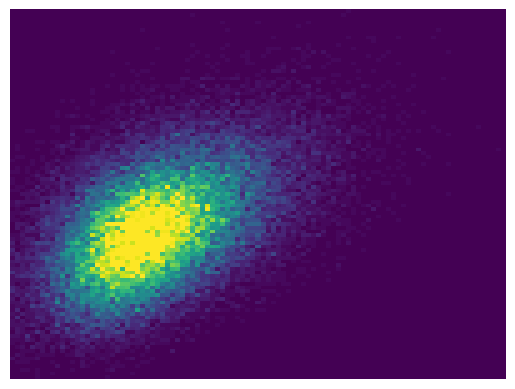

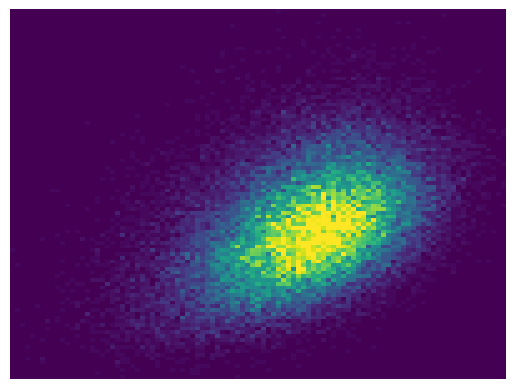

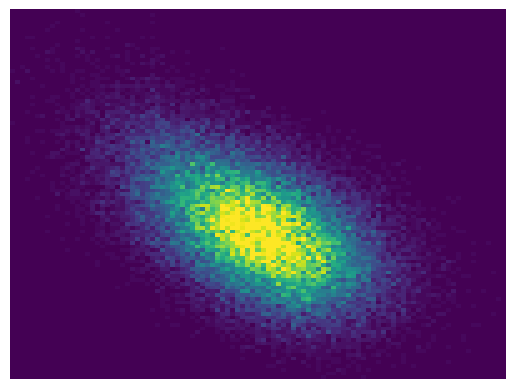

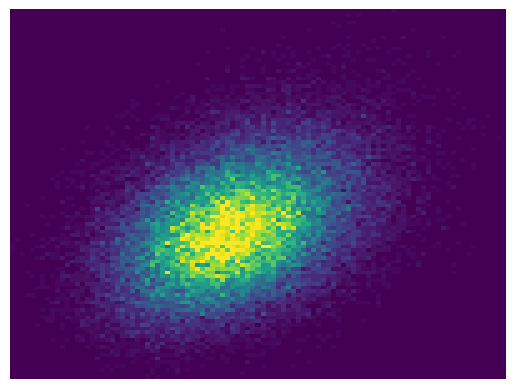

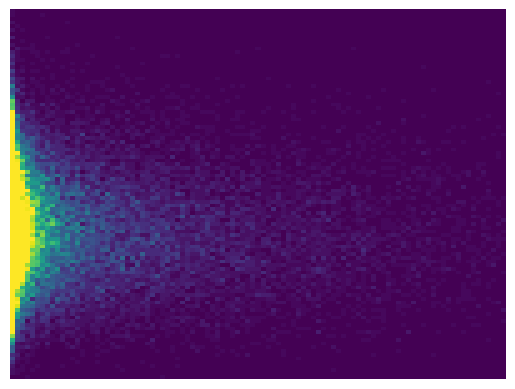

In [50]:
nPara=6
iChain=0 #select the chain (three in total)
for i in range(nPara):
     # this loop travel through all theta combinations
    for j in range(i):
        #load theta trace
        theta_collection=Population_data.posterior['test'].values[iChain]

        a=np.exp(theta_collection[:,j])
        b=np.exp(theta_collection[:,i])

            #bound and step for heat map
        a_max, a_min, a_len = max(a), min(a), (max(a)- min(a))/100
        b_max, b_min, b_len = max(b), min(b), (max(b)- min(b))/100

            #plot heatmap
        corrcoef=np.corrcoef(a,b)[0,1].round(4)
        heatmap = plt.hist2d(a, b, bins = (np.arange(a_min,a_max,a_len),np.arange(b_min,b_max,b_len)), vmin=0, vmax=50)
        plt.axis('off')
        plt.savefig(f'results/correlation/population/corr_{i+1}_{j+1}_{corrcoef}.png')
        plt.show()

In [44]:
def population_d_curve(log_mean, log_std):
    pop_true_curve = np.zeros((nSubject, nCondition, nBlock))
    for iSubject in range(nSubject):
        pop_true_curve[iSubject] = generate_z_true_curve(iSubject, z = False)
    pop_true_curve = np.mean(pop_true_curve, axis = 0)

    pop_simu_curve, pop_simu_std = generate_z_simu_curve(coef_matrix, log_mean = log_mean, log_std = log_std, z=False)    
    pop_d_true, pop_d_simu, pop_d_std = np.zeros((nDifficulty, nBlock)), np.zeros((nDifficulty, nBlock)), np.zeros((nDifficulty, nBlock))
    for i in range(nDifficulty):
        true_avg, simu_avg = (pop_true_curve[i] + pop_true_curve[i+nDifficulty])/2,  (pop_simu_curve[i] + pop_simu_curve[i+nDifficulty])/2
        pop_d_true[i], pop_d_simu[i] = stats.norm.ppf(true_avg) - stats.norm.ppf(1 - true_avg), stats.norm.ppf(simu_avg) - stats.norm.ppf(1 - simu_avg)
        pop_d_std[i] = normal_to_d(pop_simu_curve[i],pop_simu_curve[i+nDifficulty],pop_simu_std[i],pop_simu_std[i+nDifficulty])
    low_simu, low_true, low_std = pop_d_simu[0], pop_d_true[0], pop_d_std[0]
    normal_simu, normal_true, normal_std = pop_d_simu[1], pop_d_true[1], pop_d_std[1]
    high_simu, high_true, high_std = pop_d_simu[2], pop_d_true[2], pop_d_std[2]
    fig = plt.figure(figsize=(10, 6))
    start=[0,1,9,17,25,31,32]
    for i in range(6):
        part = np.arange(start[i],start[i+1])
        low_simu_part, normal_simu_part, high_simu_part=low_simu[part],normal_simu[part],high_simu[part]
        low_std_part, normal_std_part, high_std_part=low_std[part],normal_std[part],high_std[part]
        plt.plot(part, low_simu_part, color='black', marker='s', markersize=5)
        plt.plot(part, normal_simu_part, color='black', marker='o', markersize=5)
        plt.plot(part, high_simu_part, color='black', marker='^', markersize=5)
        plt.fill_between(part, low_simu_part -  low_std[part],  low_simu_part +  low_std_part, color='blue', alpha = 0.3)
        plt.fill_between(part, normal_simu_part -  normal_std[part],  normal_simu_part +  normal_std_part, color='blue',  alpha = 0.3)
        plt.fill_between(part, high_simu_part -  high_std[part],  high_simu_part +  high_std_part, color='blue',  alpha = 0.3)
    plt.plot(low_true, marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10')
    plt.plot(normal_true, marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15')
    plt.plot(high_true, marker='^', color='black',linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')
    plt.ylabel('d\'')
    plt.xlabel('Block number (300 trials/block, 4 blocks/day)')
    plt.ylim(0,3)

    legend_handles = [plt.Line2D([],[],marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                      plt.Line2D([],[],marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                      plt.Line2D([],[],marker='^',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23'),
                      plt.Line2D([], [], color='black', marker='o',markersize=3, linestyle='None', label='Model fits'),]
    plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.21, 0))
    plt.savefig(f'results/d_curve/Population',bbox_inches='tight')
    plt.show()

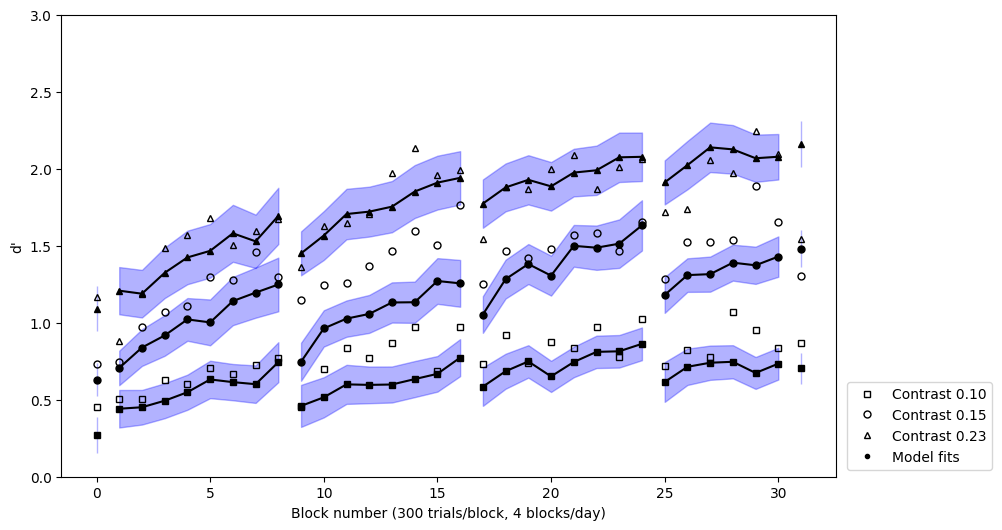

In [45]:
log_mean = pd.read_csv('results/Population Solution_NUTS.csv')['mean'][0:6]
log_std = pd.read_csv('results/Population Solution_NUTS.csv')['sd'][0:6]
population_d_curve(log_mean, log_std)

In [46]:
def subject_d_curve(log_mean, log_std, iSubject):
    sub_true_curve = generate_z_true_curve(iSubject, z = False)
    sub_simu_curve, sub_simu_std = generate_z_simu_curve(coef_matrix, log_mean = log_mean, log_std = log_std, z=False)    
    sub_d_true, sub_d_simu, sub_d_std = np.zeros((nDifficulty, nBlock)), np.zeros((nDifficulty, nBlock)), np.zeros((nDifficulty, nBlock))
    for i in range(nDifficulty):
        true_avg, simu_avg = (sub_true_curve[i] + sub_true_curve[i+nDifficulty])/2,  (sub_simu_curve[i] + sub_simu_curve[i+nDifficulty])/2
        sub_d_true[i], sub_d_simu[i] = stats.norm.ppf(true_avg) - stats.norm.ppf(1 - true_avg), stats.norm.ppf(simu_avg) - stats.norm.ppf(1 - simu_avg)
        sub_d_std[i] = normal_to_d(sub_simu_curve[i],sub_simu_curve[i+nDifficulty],sub_simu_std[i],sub_simu_std[i+nDifficulty])
    low_simu, low_true, low_std = sub_d_simu[0], sub_d_true[0], sub_d_std[0]
    normal_simu, normal_true, normal_std = sub_d_simu[1], sub_d_true[1], sub_d_std[1]
    high_simu, high_true, high_std = sub_d_simu[2], sub_d_true[2], sub_d_std[2]
    fig = plt.figure(figsize=(10, 6))
    start=[0,1,9,17,25,31,32]
    for i in range(6):
        part = np.arange(start[i],start[i+1])
        low_simu_part, normal_simu_part, high_simu_part=low_simu[part],normal_simu[part],high_simu[part]
        low_std_part, normal_std_part, high_std_part=low_std[part],normal_std[part],high_std[part]
        plt.plot(part, low_simu_part, color='black', marker='s', markersize=5)
        plt.plot(part, normal_simu_part, color='black', marker='o', markersize=5)
        plt.plot(part, high_simu_part, color='black', marker='^', markersize=5)
        plt.fill_between(part, low_simu_part -  low_std[part],  low_simu_part +  low_std_part, color='blue', alpha = 0.3)
        plt.fill_between(part, normal_simu_part -  normal_std[part],  normal_simu_part +  normal_std_part, color='blue',  alpha = 0.3)
        plt.fill_between(part, high_simu_part -  high_std[part],  high_simu_part +  high_std_part, color='blue',  alpha = 0.3)
    plt.plot(low_true, marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10')
    plt.plot(normal_true, marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15')
    plt.plot(high_true, marker='^', color='black',linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')
    plt.ylabel('d\'')
    plt.xlabel('Block number (300 trials/block, 4 blocks/day)')
    plt.ylim(0,4)

    legend_handles = [plt.Line2D([],[],marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                      plt.Line2D([],[],marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                      plt.Line2D([],[],marker='^',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23'),
                      plt.Line2D([], [], color='black', marker='o',markersize=3, linestyle='None', label='Model fits'),]
    plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.21, 0))
    plt.savefig(f'results/d_curve/Subject_{iSubject}',bbox_inches='tight')
    plt.show()

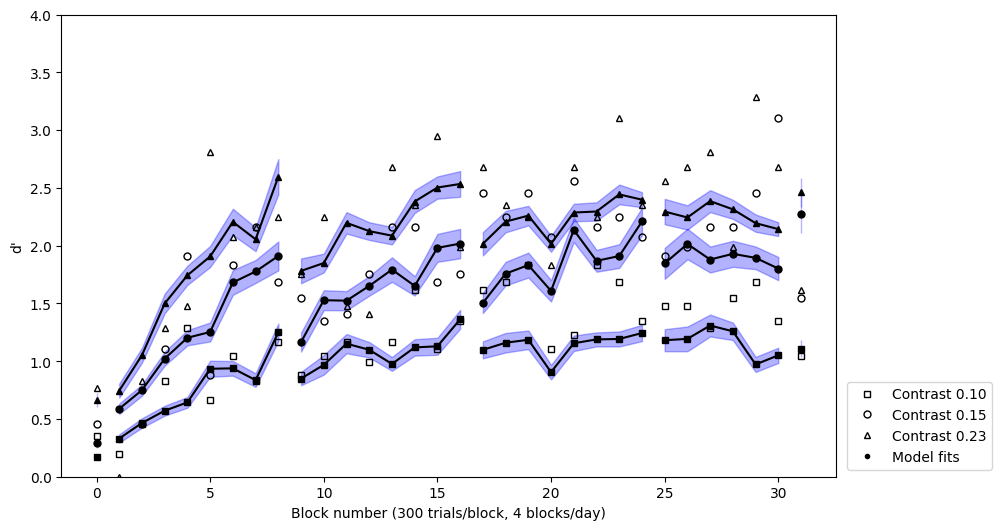

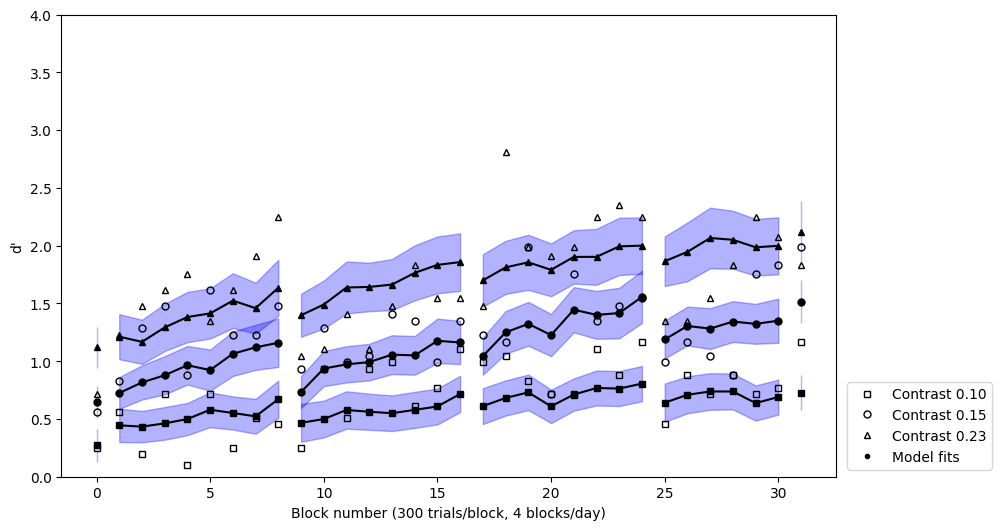

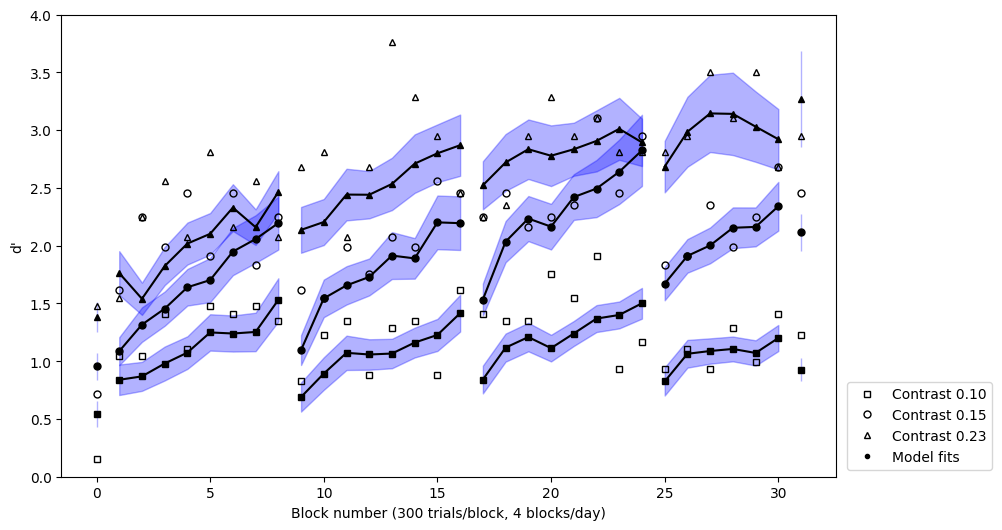

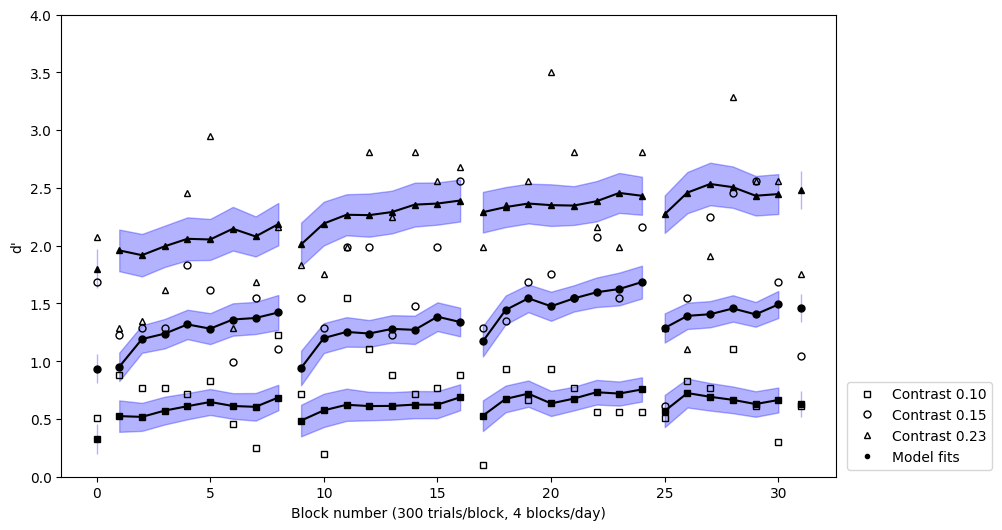

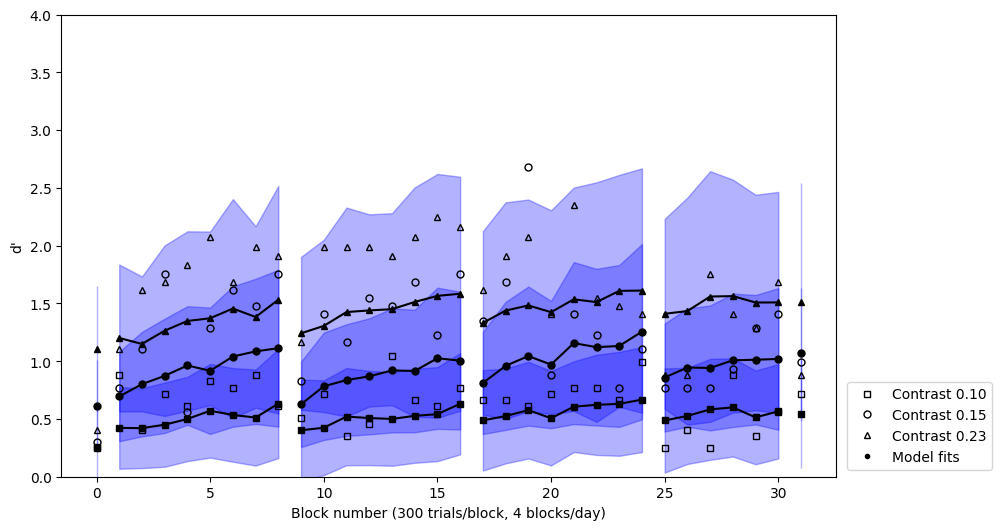

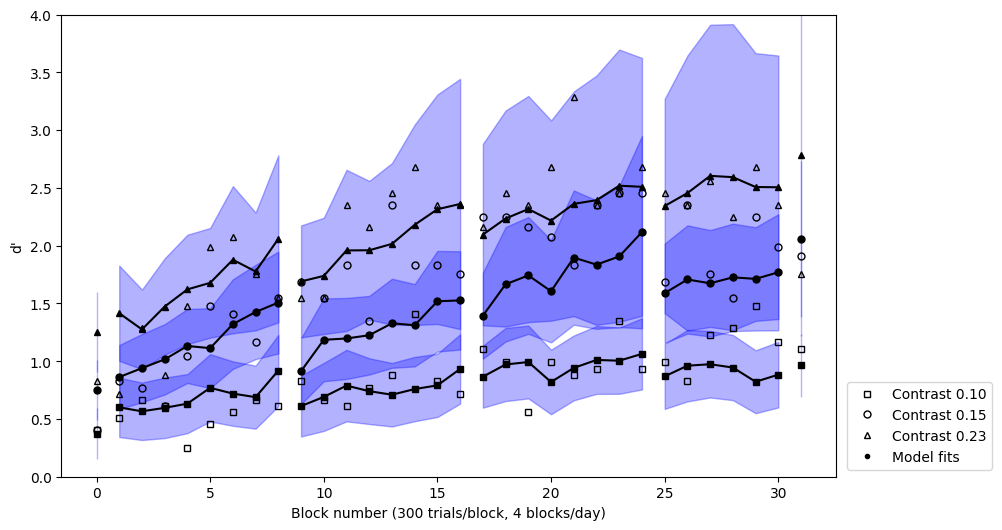

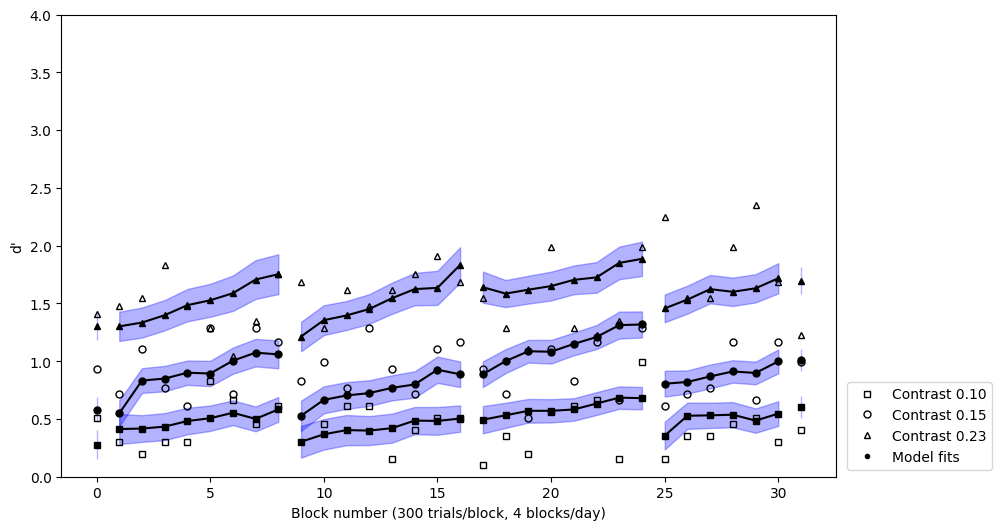

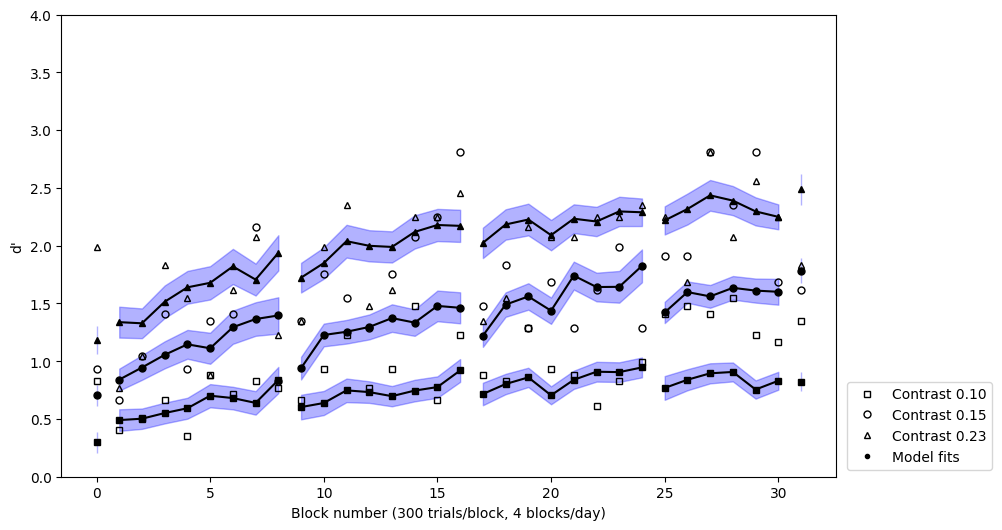

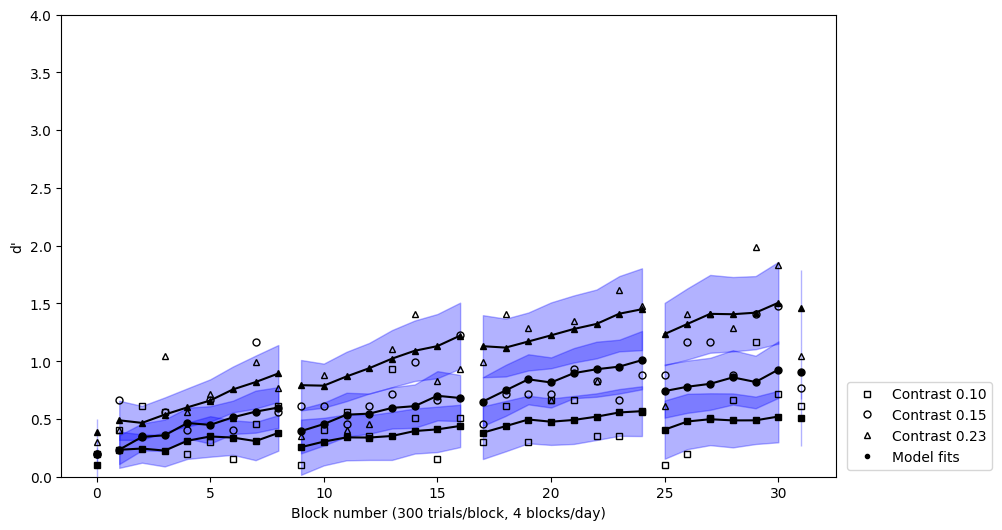

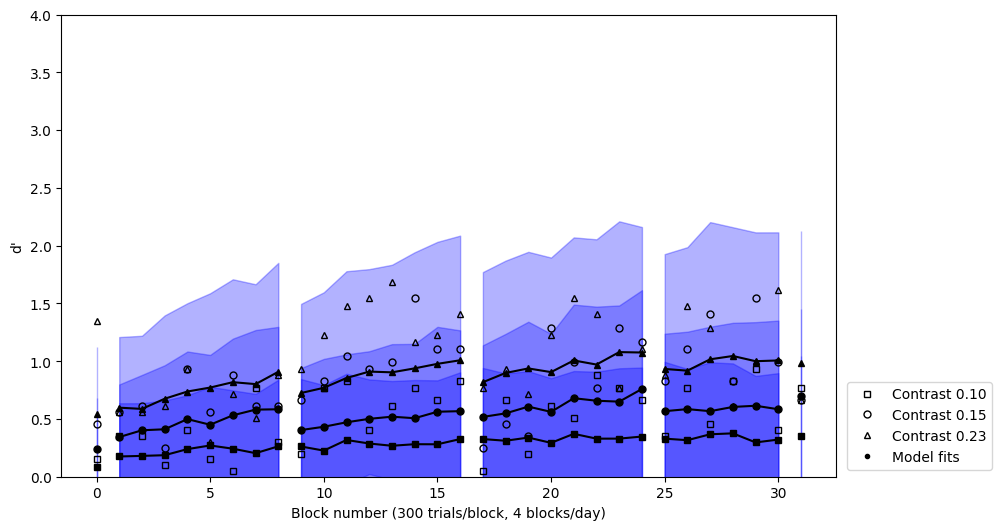

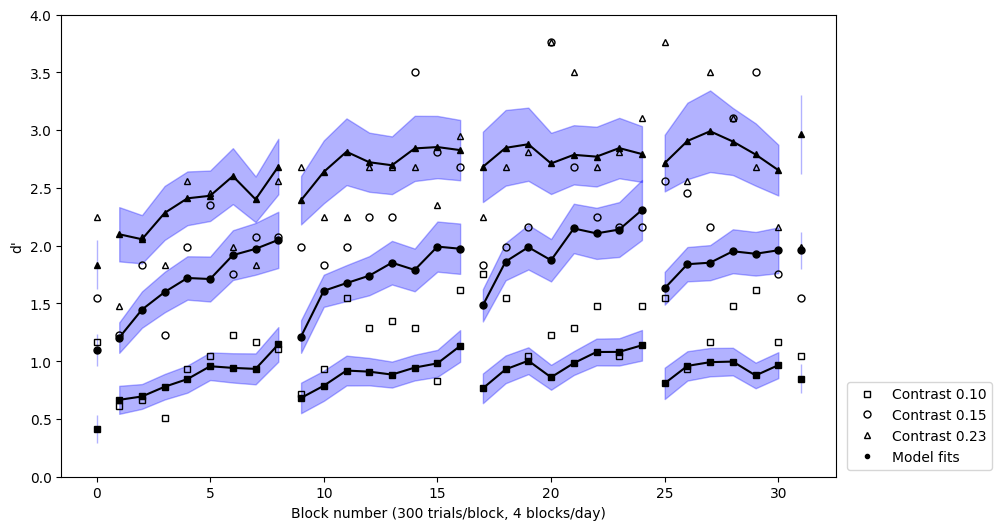

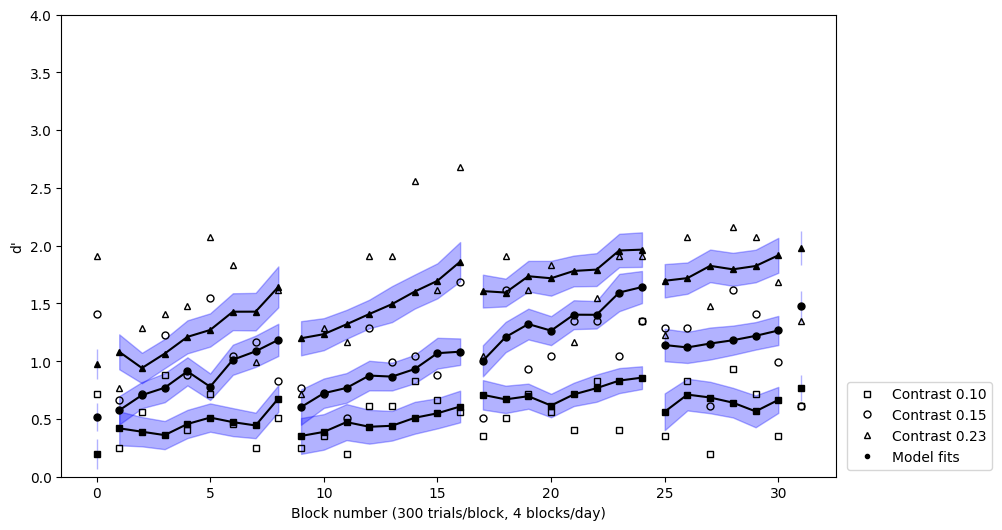

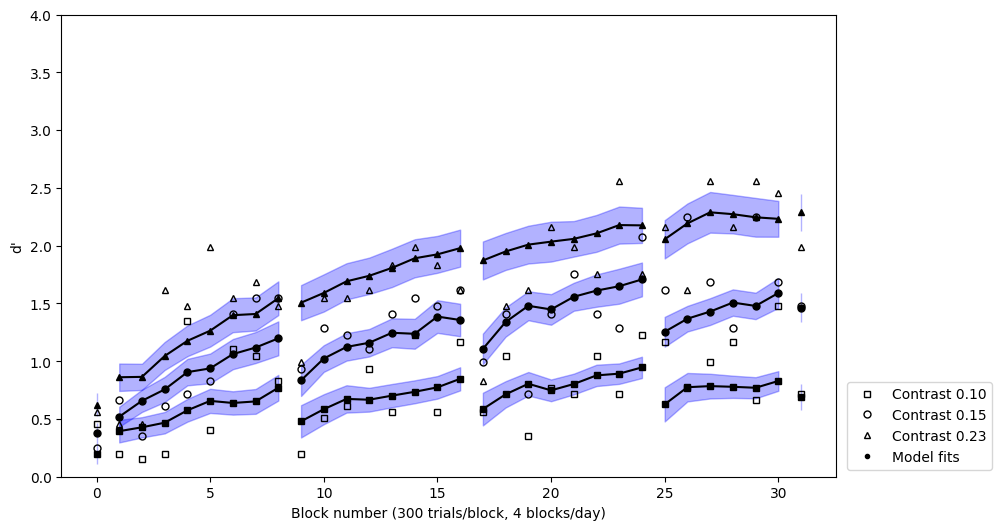

In [47]:
for iSubject in range(nSubject):
    log_mean = pd.read_csv('results/HBM Solution_NUTS.csv')['mean'][78 + iSubject * 6 : 78 + (iSubject + 1) * 6]
    log_std = pd.read_csv('results/HBM Solution_NUTS.csv')['sd'][78 + iSubject * 6 : 78 + (iSubject + 1) * 6]
    subject_d_curve(log_mean, log_std, iSubject = iSubject)